In [1]:
import pandas as pd
import glob
import numpy as np
import requests
import matplotlib.pyplot as plt

## Gathering variants
Gathering information on other variant types:
- AlphaMissense 10 most + least pathogenic variants per AD
- All gnomAD variants in AD
- All Clinvar variants in AD try 2
- **All COSMIC variants in AD**
  

Steps:
1. Use ENST code to search COSMIC for the gene. Download all variants.
2. Process output
3. Keep variants that match residue at protein position
4. Save fasta
   

In [2]:
clinvar_gene_filepaths= glob.glob('../output/caitlin_experiment/variant fastas/*')
genes = pd.DataFrame({"filepath" : clinvar_gene_filepaths})
genes["Gene"] = genes["filepath"].str.split("/").str[-1].str.split("_").str[0]
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
enst_codes = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)

# Adding uniprotID and ENST used
genes = pd.merge(known_ADs[["Gene", "uniprotID"]], genes, on = "Gene")
genes = pd.merge(enst_codes, genes, on = "uniprotID")
genes["ENST"] = genes["ENST"].str.split(".").str[0]

# Replacing ERG's ENST with the correct one
genes.loc[genes['Gene'] == 'ERG', 'ENST'] = 'ENST00000288319'
genes

,uniprotID,ENST,Gene,filepath
0,O95096,ENST00000377142,NKX2-2,../output/caitlin_experiment/variant fastas/NK...
1,P32242,ENST00000282549,OTX1,../output/caitlin_experiment/variant fastas/OT...
2,P78337,ENST00000265340,PITX1,../output/caitlin_experiment/variant fastas/PI...
3,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
4,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
5,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
6,O94983,ENST00000348066,CAMTA2,../output/caitlin_experiment/variant fastas/CA...
7,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...
8,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...
9,P11308,ENST00000288319,ERG,../output/caitlin_experiment/variant fastas/ER...


---
### 1. Use ENST code to search COSMIC for the gene. Download all variants.

In [3]:
for ENST in set(genes["ENST"]):
    print(ENST)

ENST00000348332
ENST00000288319
ENST00000241001
ENST00000265340
ENST00000331340
ENST00000339562
ENST00000282549
ENST00000358127
ENST00000377142
ENST00000348066
ENST00000561208


---
### 2. Process output

In [4]:
cosmic_files = glob.glob("../data/cosmic_by_transcript/*")

In [5]:
cosmic_vars = []

for cf in cosmic_files:
    df = pd.read_csv(cf)
    df["ENST"] = cf.split("/")[-1]
    cosmic_vars.append(df)

cosmic_vars = pd.concat(cosmic_vars)
cosmic_vars

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST
0,2.0,c.5C>A,p.P2H,COSM4501892,1,Substitution - Missense,ENST00000339562
1,6.0,c.16G>A,p.A6T,COSM1400254,1,Substitution - Missense,ENST00000339562
2,6.0,c.18G>A,p.A6=,COSM716250,2,Substitution - coding silent,ENST00000339562
3,9.0,c.26G>T,p.G9V,COSM8722140,1,Substitution - Missense,ENST00000339562
4,10.0,c.28T>C,p.S10P,COSM7585902,1,Substitution - Missense,ENST00000339562
...,...,...,...,...,...,...,...
313,NaN,c.*830_*831del,p.?,COSN29527585,1,Unknown,ENST00000282549
314,NaN,c.*832C>T,p.?,COSN33260133,1,Unknown,ENST00000282549
315,NaN,c.*834T>C,p.?,COSN16555384,1,Unknown,ENST00000282549
316,NaN,c.*910A>G,p.?,COSN33061728,5,Unknown,ENST00000282549


In [38]:
cosmic_vars.to_csv("../data/all_cosmic_vars.csv")

In [6]:
cosmic_missense = cosmic_vars[cosmic_vars["Type"].str.contains("Missense")]
cosmic_missense["Type"].value_counts()

Type
Substitution - Missense    2865
Name: count, dtype: int64

In [7]:
cosmic_missense = cosmic_missense.reset_index(drop = True)
cosmic_missense

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST
0,2.0,c.5C>A,p.P2H,COSM4501892,1,Substitution - Missense,ENST00000339562
1,6.0,c.16G>A,p.A6T,COSM1400254,1,Substitution - Missense,ENST00000339562
2,9.0,c.26G>T,p.G9V,COSM8722140,1,Substitution - Missense,ENST00000339562
3,10.0,c.28T>C,p.S10P,COSM7585902,1,Substitution - Missense,ENST00000339562
4,10.0,c.29C>T,p.S10F,COSM8136807,1,Substitution - Missense,ENST00000339562
...,...,...,...,...,...,...,...
2860,345.0,c.1033G>A,p.D345N,COSM6158712,1,Substitution - Missense,ENST00000282549
2861,347.0,c.1039G>A,p.A347T,COSM7465094,2,Substitution - Missense,ENST00000282549
2862,350.0,c.1048C>T,p.R350W,COSM1022193,5,Substitution - Missense,ENST00000282549
2863,350.0,c.1049G>A,p.R350Q,COSM1668980,1,Substitution - Missense,ENST00000282549


In [8]:
# Extracting ref and alt nt
# To look for only 
ref_and_alt = cosmic_missense["CDS Mutation"].str.extract(r'c\.\d+([ACGT]+)>([ACGT+])')
ref_and_alt["ref_lens"] = ref_and_alt[0].str.len()
ref_and_alt["alt_lens"] = ref_and_alt[1].str.len()
ref_and_alt

,0,1,ref_lens,alt_lens
0,C,A,1.0,1.0
1,G,A,1.0,1.0
2,G,T,1.0,1.0
3,T,C,1.0,1.0
4,C,T,1.0,1.0
...,...,...,...,...
2860,G,A,1.0,1.0
2861,G,A,1.0,1.0
2862,C,T,1.0,1.0
2863,G,A,1.0,1.0


In [9]:
ref_and_alt[ref_and_alt["ref_lens"]!= 1]

,0,1,ref_lens,alt_lens
277,NaN,NaN,NaN,NaN
443,NaN,NaN,NaN,NaN
445,NaN,NaN,NaN,NaN
659,NaN,NaN,NaN,NaN
848,NaN,NaN,NaN,NaN
870,NaN,NaN,NaN,NaN
988,NaN,NaN,NaN,NaN
1247,NaN,NaN,NaN,NaN
1248,NaN,NaN,NaN,NaN
1285,NaN,NaN,NaN,NaN


In [10]:
cosmic_missense.loc[277]

Position                                150.0
CDS Mutation                c.447_448delinsAA
AA Mutation                           p.E150K
Legacy Mutation ID                COSM4566700
Count                                       1
Type                  Substitution - Missense
ENST                          ENST00000348332
Name: 277, dtype: object

In [11]:
cosmic_missense[~cosmic_missense["CDS Mutation"].str.contains(">")]

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST
277,150.0,c.447_448delinsAA,p.E150K,COSM4566700,1,Substitution - Missense,ENST00000348332
443,725.0,c.2172_2175delinsATCC,p.V725S,COSM9820130,1,Substitution - Missense,ENST00000348332
445,728.0,c.2183_2185delinsGTG,p.N728_S729delinsSA,COSM9820132,1,Substitution - Missense,ENST00000348332
659,1416.0,c.4246_4247delinsAA,p.G1416K,COSM5396697,1,Substitution - Missense,ENST00000348332
848,90.0,c.267_268delinsTT,p.L90F,COSM10242961,1,Substitution - Missense,ENST00000348066
870,179.0,c.534_535delinsAA,p.E179K,COSM9870202,1,Substitution - Missense,ENST00000348066
988,606.0,c.1815_1816delinsTT,p.L606F,COSM5852939,1,Substitution - Missense,ENST00000348066
1247,115.0,c.343_344delinsAA,p.G115K,COSM4566300,1,Substitution - Missense,ENST00000331340
1248,115.0,c.343_344delinsAT,p.G115I,COSM4566301,1,Substitution - Missense,ENST00000331340
1285,158.0,c.471_472delinsAA,p.G158S,COSM9656575,1,Substitution - Missense,ENST00000331340


Talked to caitlin: plan include all

-  So I will use AA mutation column instead of CDS
- Handle delins separately from the rest

In [12]:
cosmic_missense_delins = cosmic_missense[cosmic_missense["AA Mutation"].str.contains("delins")]
cosmic_missense_delins

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST
445,728.0,c.2183_2185delinsGTG,p.N728_S729delinsSA,COSM9820132,1,Substitution - Missense,ENST00000348332
1557,446.0,c.1338_1339delinsTC,p.Q446_D447delinsHH,COSM6946657,1,Substitution - Missense,ENST00000331340
1603,500.0,c.1500_1501delinsTT,p.Q500_D501delinsHY,COSM6178133,1,Substitution - Missense,ENST00000331340


In [13]:
AA_orig_pt1_regex = 'p\.(.)\d\d\d'
AA_orig_pt2_regex = '_(.)\d\d\d'
AA_new_regex = 'delins(..)'
AA_pos_regex = 'p\..(\d\d\d)'
cosmic_missense_delins["AA_orig"] = cosmic_missense_delins["AA Mutation"].str.extract(AA_orig_pt1_regex) + cosmic_missense_delins["AA Mutation"].str.extract(AA_orig_pt2_regex)
cosmic_missense_delins["AA_new"] = cosmic_missense_delins["AA Mutation"].str.extract(AA_new_regex)
cosmic_missense_delins["AA_pos"] = cosmic_missense_delins["AA Mutation"].str.extract(AA_pos_regex).astype(int)
cosmic_missense_delins

/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_39947/1524039247.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosmic_missense_delins["AA_orig"] = cosmic_missense_delins["AA Mutation"].str.extract(AA_orig_pt1_regex) + cosmic_missense_delins["AA Mutation"].str.extract(AA_orig_pt2_regex)
/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_39947/1524039247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosmic_missense_delins["AA_new"] = cosmic_missense_delins["AA Mutation"].str.ext

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos
445,728.0,c.2183_2185delinsGTG,p.N728_S729delinsSA,COSM9820132,1,Substitution - Missense,ENST00000348332,NS,SA,728
1557,446.0,c.1338_1339delinsTC,p.Q446_D447delinsHH,COSM6946657,1,Substitution - Missense,ENST00000331340,QD,HH,446
1603,500.0,c.1500_1501delinsTT,p.Q500_D501delinsHY,COSM6178133,1,Substitution - Missense,ENST00000331340,QD,HY,500


In [14]:
cosmic_missense_not_delins = cosmic_missense[~cosmic_missense["AA Mutation"].str.contains("delins")]
cosmic_missense_not_delins

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST
0,2.0,c.5C>A,p.P2H,COSM4501892,1,Substitution - Missense,ENST00000339562
1,6.0,c.16G>A,p.A6T,COSM1400254,1,Substitution - Missense,ENST00000339562
2,9.0,c.26G>T,p.G9V,COSM8722140,1,Substitution - Missense,ENST00000339562
3,10.0,c.28T>C,p.S10P,COSM7585902,1,Substitution - Missense,ENST00000339562
4,10.0,c.29C>T,p.S10F,COSM8136807,1,Substitution - Missense,ENST00000339562
...,...,...,...,...,...,...,...
2860,345.0,c.1033G>A,p.D345N,COSM6158712,1,Substitution - Missense,ENST00000282549
2861,347.0,c.1039G>A,p.A347T,COSM7465094,2,Substitution - Missense,ENST00000282549
2862,350.0,c.1048C>T,p.R350W,COSM1022193,5,Substitution - Missense,ENST00000282549
2863,350.0,c.1049G>A,p.R350Q,COSM1668980,1,Substitution - Missense,ENST00000282549


In [15]:
AA_orig_regex = 'p\.([A-Z]+)\d+'
AA_new_regex = '\d+([A-Z]+)'
AA_pos_regex = 'p\.[A-Z]+(\d+)'
cosmic_missense_not_delins["AA_orig"] = cosmic_missense_not_delins["AA Mutation"].str.extract(AA_orig_regex)
cosmic_missense_not_delins["AA_new"] = cosmic_missense_not_delins["AA Mutation"].str.extract(AA_new_regex)
cosmic_missense_not_delins["AA_pos"] = cosmic_missense_not_delins["AA Mutation"].str.extract(AA_pos_regex).astype(int)
cosmic_missense_not_delins

/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_39947/2436089443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosmic_missense_not_delins["AA_orig"] = cosmic_missense_not_delins["AA Mutation"].str.extract(AA_orig_regex)
/var/folders/hw/xx051vr9457c7lrngf2mypgr0000gn/T/ipykernel_39947/2436089443.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cosmic_missense_not_delins["AA_new"] = cosmic_missense_not_delins["AA Mutation"].str.extract(AA_new_regex)
/var/folders/hw/xx051vr9457c7lrngf2mypgr

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos
0,2.0,c.5C>A,p.P2H,COSM4501892,1,Substitution - Missense,ENST00000339562,P,H,2
1,6.0,c.16G>A,p.A6T,COSM1400254,1,Substitution - Missense,ENST00000339562,A,T,6
2,9.0,c.26G>T,p.G9V,COSM8722140,1,Substitution - Missense,ENST00000339562,G,V,9
3,10.0,c.28T>C,p.S10P,COSM7585902,1,Substitution - Missense,ENST00000339562,S,P,10
4,10.0,c.29C>T,p.S10F,COSM8136807,1,Substitution - Missense,ENST00000339562,S,F,10
...,...,...,...,...,...,...,...,...,...,...
2860,345.0,c.1033G>A,p.D345N,COSM6158712,1,Substitution - Missense,ENST00000282549,D,N,345
2861,347.0,c.1039G>A,p.A347T,COSM7465094,2,Substitution - Missense,ENST00000282549,A,T,347
2862,350.0,c.1048C>T,p.R350W,COSM1022193,5,Substitution - Missense,ENST00000282549,R,W,350
2863,350.0,c.1049G>A,p.R350Q,COSM1668980,1,Substitution - Missense,ENST00000282549,R,Q,350


---
### 3. Keep variants that match residue at protein position.

In [16]:
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
known_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
0,ABRAXAS1,121,200,Q6UWZ7,[['Q6UWZ7']],ENST00000321945,Q6UWZ7,DelRosso et al.,CR,LQEHFSNQDLVFLLLTPSIITESCSTHRLEHSLYKPQKGLFHRVPL...,NaN
1,AEBP1,1088,1158,Q8IUX7,[['Q8IUX7']],NaN,Q8IUX7,Staller Activity Data,TF,EVVTEFGTEVEPEFGTKVEPEFETQLEPEFETQLEPEFEEEEEEEK...,NaN
2,AHCTF1,1445,1698,Q8WYP5,"[['Q8WYP5'], ['Q8WYP5']]",nan / nan,Q8WYP5 / Q8WYP5,"PMID: 11952839, Soto / transcriptionalactivity...",TF,IRANDNKSMADVLGDGGNSSLTISEGPIVSERRLNQEVALNLKEDH...,NaN
3,AHR,118,126,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,LLQALNGFV,NaN
4,AHR,266,268,P35869,[['P35869']],NaN,P35869,"transcriptionalactivity_regions.txt, GSL",TF,FAI,NaN
...,...,...,...,...,...,...,...,...,...,...,...
739,ZSCAN20,262,341,P17040,"[['P17040', 'P17040-3']]",ENST00000361328,P17040,DelRosso et al.,TF,PSNTSEKEQGPEFWGLSLINSGKRSTADYSLDNEPAQALTWRDSRA...,NaN
740,ZXDA,572,699,P98168,"[['P98168'], ['P98168']]",nan / nan,P98168 / P98168 / P98168,"PMID: 17493635, Soto / R4TA_regions.txt / acti...",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN
741,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,NaN
742,ZXDC,579,688,Q2QGD7,"[['Q2QGD7', 'Q2QGD7-2'], ['Q2QGD7', 'Q2QGD7-2']]",nan / nan,Q2QGD7 / Q2QGD7 / Q2QGD7,"PMID: 16600381, Soto / R4TA_regions.txt / acti...",TF,DSPLVLGTAATVLQQGSFSVDDVQTVSAGALGCLVALPMKNLSDDP...,NaN


In [17]:
target_ADs = known_ADs[known_ADs["uniprotID"].isin(genes["uniprotID"])]
target_ADs

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
48,CAMTA2,285,468,O94983,"[['O94983', 'O94983-2'], ['O94983', 'O94983-2']]",nan / ENST00000348066,O94983 / O94983,"PMID: 16678093, Soto / DelRosso et al.",TF,KAHTSPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,NaN
49,CAMTA2,472,581,O94983,"[['O94983', 'O94983-2']]",ENST00000348066,O94983,DelRosso et al.,TF,SPAPLEPSSRVGRGEALFGGPVGASELEPFSLSSFPDLMGELISDE...,NaN
125,ERG,433,479,P11308,[['P11308-3']],NaN,P11308,"PMID: 9681824, Soto",TF,PHPPALPVTSSSFFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,NaN
126,ERG,118,261,P11308,"[['P11308-1', 'P11308-3', 'P11308-5', 'P11308-...",nan / ENST00000288319,P11308 / P11308,"PMID: 14603248, Soto / DelRosso et al.",TF,MTTNERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,NaN
267,IKZF1,284,365,Q13422,[['Q13422']],NaN,Q13422,"PMID: 8895580, Soto",TF,GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRP...,NaN
333,MEIS2,340,477,O14770,[['O14770']],NaN,O14770,"activation_regions.txt, GSL",TF,DQSNRAGFLLDPSVSQGAAYSPEGQPMGSFVLDGQQHMGIRPAGLQ...,NaN
372,NCOA1,1,93,Q15788,"[['Q15788', 'Q15788-2', 'Q15788-3']]",NaN,Q15788,"PMID: 9575154, Soto",TF,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,NaN
373,NCOA1,1241,1385,Q15788,"[['Q15788', 'Q15788-2', 'Q15788-3']]",NaN,Q15788,"PMID: 9427757, Soto",TF,GEANFAPSLSPGSSMVPMPIPPPQSSLLQQTPPASGYQSPDMKAWQ...,NaN
374,NCOA1,840,1011,Q15788,"[['Q15788', 'Q15788-2', 'Q15788-3'], ['Q15788-...",nan / ENST00000288599,Q15788 / Q15788,"PMID: 9427757, 9575154, Soto / DelRosso et al.",TF,VTSVTIKSEILPASLQSATARPTSRLNRLPELELEAIDNQFGQPGT...,NaN
411,NKX2-2,220,273,O95096,[['O95096']],NaN,O95096,"PMID: 10944215, Soto",TF,AQDLAAATFQAGIPFSAYSAQSLQHMQYNAQYSSASTPQYPTAHPL...,NaN


In [18]:
index = 48
index

48

In [19]:
AD_vars_not_delins = []

for index in target_ADs.index:

    gene_mismatch = False

    # For each AD, filter non delin variants to those in range
    gene = target_ADs["Gene"].loc[index]
    AD_start = target_ADs["Start"].loc[index]
    AD_end = target_ADs["End"].loc[index]
    AD_seq = target_ADs["ProteinRegionSeq"].loc[index]
    ENST = genes[genes["Gene"] == gene]["ENST"].iloc[0]

    # Keep vars within AD
    ENST_not_delins = cosmic_missense_not_delins[cosmic_missense_not_delins["ENST"] == ENST]
    AD_ENST_not_delins = ENST_not_delins[(AD_start < ENST_not_delins["AA_pos"]) & (ENST_not_delins["AA_pos"] < AD_end)]
    AD_vars_not_delins.append(AD_ENST_not_delins)
        
    # Use to check correct AA
    pos_to_aa = dict(zip(np.arange(AD_start, AD_end + 1), list(AD_seq)))
    for i in AD_ENST_not_delins.index:
        obs = AD_ENST_not_delins["AA_orig"].loc[i]
        exp = pos_to_aa[AD_ENST_not_delins["AA_pos"].loc[i]]
        if obs != exp:
            gene_mismatch = True

    if gene_mismatch:
        print("Check " + gene)
    else:
        print(gene + " all good!")

AD_vars_not_delins = pd.concat(AD_vars_not_delins).reset_index(drop = True)
AD_vars_not_delins

CAMTA2 all good!
CAMTA2 all good!
ERG all good!
ERG all good!
IKZF1 all good!
MEIS2 all good!
NCOA1 all good!
NCOA1 all good!
NCOA1 all good!
NKX2-2 all good!
NR4A2 all good!
NR4A2 all good!
OTX1 all good!
PAX5 all good!
PAX6 all good!
PITX1 all good!


,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos
0,286.0,c.857C>T,p.A286V,COSM6619642,1,Substitution - Missense,ENST00000348066,A,V,286
1,289.0,c.866C>T,p.S289F,COSM436916,1,Substitution - Missense,ENST00000348066,S,F,289
2,293.0,c.878C>T,p.S293F,COSM8480071,1,Substitution - Missense,ENST00000348066,S,F,293
3,304.0,c.910C>A,p.P304T,COSM115792,2,Substitution - Missense,ENST00000348066,P,T,304
4,307.0,c.921C>G,p.I307M,COSM8641706,1,Substitution - Missense,ENST00000348066,I,M,307
...,...,...,...,...,...,...,...,...,...,...
685,263.0,c.788C>T,p.P263L,COSM6746937,1,Substitution - Missense,ENST00000265340,P,L,263
686,265.0,c.793G>A,p.G265S,COSM7495260,1,Substitution - Missense,ENST00000265340,G,S,265
687,269.0,c.806C>G,p.S269W,COSM462078,1,Substitution - Missense,ENST00000265340,S,W,269
688,273.0,c.817G>A,p.V273I,COSM72185,4,Substitution - Missense,ENST00000265340,V,I,273


In [20]:
# Previously mismatched above
# For ERG, will redo to sesarch for ENST00000288319 instead to be consistent with known ADs
# Editing code above

In [21]:
# Manually processing this 
cosmic_missense_delins

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos
445,728.0,c.2183_2185delinsGTG,p.N728_S729delinsSA,COSM9820132,1,Substitution - Missense,ENST00000348332,NS,SA,728
1557,446.0,c.1338_1339delinsTC,p.Q446_D447delinsHH,COSM6946657,1,Substitution - Missense,ENST00000331340,QD,HH,446
1603,500.0,c.1500_1501delinsTT,p.Q500_D501delinsHY,COSM6178133,1,Substitution - Missense,ENST00000331340,QD,HY,500


In [22]:
genes[genes["ENST"] == "ENST00000348332"]

,uniprotID,ENST,Gene,filepath
13,Q15788,ENST00000348332,NCOA1,../output/caitlin_experiment/variant fastas/NC...
14,Q15788,ENST00000348332,NCOA1,../output/caitlin_experiment/variant fastas/NC...
15,Q15788,ENST00000348332,NCOA1,../output/caitlin_experiment/variant fastas/NC...
16,Q15788,ENST00000348332,NCOA1,../output/caitlin_experiment/variant fastas/NC...
17,Q15788,ENST00000348332,NCOA1,../output/caitlin_experiment/variant fastas/NC...
18,Q15788,ENST00000348332,NCOA1,../output/caitlin_experiment/variant fastas/NC...


In [23]:
known_ADs[known_ADs["Gene"] == "NCOA1"]

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
372,NCOA1,1,93,Q15788,"[['Q15788', 'Q15788-2', 'Q15788-3']]",NaN,Q15788,"PMID: 9575154, Soto",TF,MSGLGDSSSDPANPDSHKRKGSPCDTLASSTEKRRREQENKYLEEL...,NaN
373,NCOA1,1241,1385,Q15788,"[['Q15788', 'Q15788-2', 'Q15788-3']]",NaN,Q15788,"PMID: 9427757, Soto",TF,GEANFAPSLSPGSSMVPMPIPPPQSSLLQQTPPASGYQSPDMKAWQ...,NaN
374,NCOA1,840,1011,Q15788,"[['Q15788', 'Q15788-2', 'Q15788-3'], ['Q15788-...",nan / ENST00000288599,Q15788 / Q15788,"PMID: 9427757, 9575154, Soto / DelRosso et al.",TF,VTSVTIKSEILPASLQSATARPTSRLNRLPELELEAIDNQFGQPGT...,NaN


In [24]:
#  NCOA pos 728 is not in the AD
# now checking others

In [25]:
genes[genes["ENST"] == "ENST00000331340"]

,uniprotID,ENST,Gene,filepath
11,Q13422,ENST00000331340,IKZF1,../output/caitlin_experiment/variant fastas/IK...


In [26]:
known_ADs[known_ADs["Gene"] == "IKZF1"]

,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,Notes
267,IKZF1,284,365,Q13422,[['Q13422']],NaN,Q13422,"PMID: 8895580, Soto",TF,GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRP...,NaN


In [27]:
# IKZF1 pos 446 and 500 are not in the AD

In [28]:
# So these are all of the relevant vars:

AD_vars_not_delins

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos
0,286.0,c.857C>T,p.A286V,COSM6619642,1,Substitution - Missense,ENST00000348066,A,V,286
1,289.0,c.866C>T,p.S289F,COSM436916,1,Substitution - Missense,ENST00000348066,S,F,289
2,293.0,c.878C>T,p.S293F,COSM8480071,1,Substitution - Missense,ENST00000348066,S,F,293
3,304.0,c.910C>A,p.P304T,COSM115792,2,Substitution - Missense,ENST00000348066,P,T,304
4,307.0,c.921C>G,p.I307M,COSM8641706,1,Substitution - Missense,ENST00000348066,I,M,307
...,...,...,...,...,...,...,...,...,...,...
685,263.0,c.788C>T,p.P263L,COSM6746937,1,Substitution - Missense,ENST00000265340,P,L,263
686,265.0,c.793G>A,p.G265S,COSM7495260,1,Substitution - Missense,ENST00000265340,G,S,265
687,269.0,c.806C>G,p.S269W,COSM462078,1,Substitution - Missense,ENST00000265340,S,W,269
688,273.0,c.817G>A,p.V273I,COSM72185,4,Substitution - Missense,ENST00000265340,V,I,273


---
### 4. Save csv file

Dont have genomic coordinates, so will write script here to save as csv file

In [29]:
aa_dict = {
    'A': 'Ala',  # Alanine
    'R': 'Arg',  # Arginine
    'N': 'Asn',  # Asparagine
    'D': 'Asp',  # Aspartic acid
    'C': 'Cys',  # Cysteine
    'E': 'Glu',  # Glutamic acid
    'Q': 'Gln',  # Glutamine
    'G': 'Gly',  # Glycine
    'H': 'His',  # Histidine
    'I': 'Ile',  # Isoleucine
    'L': 'Leu',  # Leucine
    'K': 'Lys',  # Lysine
    'M': 'Met',  # Methionine
    'F': 'Phe',  # Phenylalanine
    'P': 'Pro',  # Proline
    'S': 'Ser',  # Serine
    'T': 'Thr',  # Threonine
    'W': 'Trp',  # Tryptophan
    'Y': 'Tyr',  # Tyrosine
    'V': 'Val',  # Valine
}


In [30]:
AD_vars_share_format = []

for index in target_ADs.index:

    # For each AD, filter non delin variants to those in range
    gene = target_ADs["Gene"].loc[index]
    AD_start = target_ADs["Start"].loc[index]
    AD_end = target_ADs["End"].loc[index]
    AD_seq = target_ADs["ProteinRegionSeq"].loc[index]
    ENST = genes[genes["Gene"] == gene]["ENST"].iloc[0]

    # Keep vars within AD
    AD_vars = AD_vars_not_delins[AD_vars_not_delins["ENST"] == ENST]
    AD_vars = AD_vars[(AD_start < AD_vars["AA_pos"]) & (AD_vars["AA_pos"] < AD_end)]

    var_seqs = []
    aa_changes = []
    
    # Substitute one var at a time
    for i in AD_vars.index:
        new_aa = AD_vars["AA_new"].loc[i]
        pos = AD_vars["AA_pos"].loc[i]
        
        pos_to_aa_df = pd.DataFrame({"pos":np.arange(AD_start, AD_end + 1), "aa":list(AD_seq)})
        pos_to_aa_df = pos_to_aa_df.set_index("pos")

        old_aa = pos_to_aa_df.at[pos, "aa"]
        pos_to_aa_df.at[pos, "aa"] = new_aa
        var_seq = "".join(pos_to_aa_df["aa"])
        
        var_seqs.append(var_seq)
        aa_changes.append("p." + aa_dict[old_aa] + str(pos) + aa_dict[new_aa])

    AD_vars["Mutant Sequence"] = var_seqs
    AD_vars["Protein Change"] = aa_changes
    AD_vars["gene"] = gene
    AD_vars["start"] = AD_start
    AD_vars["end"] = AD_end

    AD_vars = AD_vars[["gene", "start", "end", "Protein Change", "Mutant Sequence"]]
    AD_vars_share_format.append(AD_vars)

AD_vars_share_format = pd.concat(AD_vars_share_format)
AD_vars_share_format

,gene,start,end,Protein Change,Mutant Sequence
0,CAMTA2,285,468,p.Ala286Val,KVHTSPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...
1,CAMTA2,285,468,p.Ser289Phe,KAHTFPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...
2,CAMTA2,285,468,p.Ser293Phe,KAHTSPSSFSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...
3,CAMTA2,285,468,p.Pro304Thr,KAHTSPSSSSSSSSSGFAETLEIRPSPPTSRGGSSRGGTAILLLTG...
4,CAMTA2,285,468,p.Ile307Met,KAHTSPSSSSSSSSSGFAEPLEMRPSPPTSRGGSSRGGTAILLLTG...
...,...,...,...,...,...
685,PITX1,234,283,p.Pro263Leu,VPGMPNSGLNNINNLTGSSLNSAMSPGACLYGTPASPYSVYRDTCN...
686,PITX1,234,283,p.Gly265Ser,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYSTPASPYSVYRDTCN...
687,PITX1,234,283,p.Ser269Trp,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPAWPYSVYRDTCN...
688,PITX1,234,283,p.Val273Ile,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPASPYSIYRDTCN...


In [31]:
cc_names = pd.read_excel("../data/gene_names_with_location_and_pmvs.xlsx")
cc_names

,pMVS #,Gene Name,gene,start,end
0,377,MEIS2_AD,MEIS2,340,477
1,402,IKZF1_AD,IKZF1,284,365
2,405,CAMTA2_AD2,CAMTA2,472,581
3,409,PITX1_AD,PITX1,234,283
4,383,NR4A2_AD2,NR4A2,584,598
5,404,CAMTA2_AD1,CAMTA2,285,468
6,407,OTX1_AD,OTX1,172,354
7,410,PAX5_AD,PAX5,304,358
8,403,PAX6_AD,PAX6,271,422
9,379,NCOA1_AD2,NCOA1,1241,1385


In [32]:
AD_vars_share_format_cc_names = pd.merge(AD_vars_share_format, cc_names)
AD_vars_share_format_cc_names = AD_vars_share_format_cc_names[["Gene Name", "Mutant Sequence", "Protein Change"]]
AD_vars_share_format_cc_names["Mutation"] = "cosmic"
AD_vars_share_format_cc_names = AD_vars_share_format_cc_names.drop_duplicates(subset = "Mutant Sequence")
AD_vars_share_format_cc_names

,Gene Name,Mutant Sequence,Protein Change,Mutation
0,CAMTA2_AD1,KVHTSPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ala286Val,cosmic
1,CAMTA2_AD1,KAHTFPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser289Phe,cosmic
2,CAMTA2_AD1,KAHTSPSSFSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser293Phe,cosmic
3,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAETLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Pro304Thr,cosmic
4,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAEPLEMRPSPPTSRGGSSRGGTAILLLTG...,p.Ile307Met,cosmic
...,...,...,...,...
647,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACLYGTPASPYSVYRDTCN...,p.Pro263Leu,cosmic
648,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYSTPASPYSVYRDTCN...,p.Gly265Ser,cosmic
649,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPAWPYSVYRDTCN...,p.Ser269Trp,cosmic
650,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPASPYSIYRDTCN...,p.Val273Ile,cosmic


In [33]:
#AD_vars_share_format_cc_names.to_csv("../output/caitlin_experiment/cosmic_vars.csv")

In [34]:
pd.DataFrame(AD_vars_share_format_cc_names["Gene Name"].value_counts()).to_csv("../output/caitlin_experiment/cosmic_counts.csv")
pd.DataFrame(AD_vars_share_format_cc_names["Gene Name"].value_counts())

,count
Gene Name,
OTX1_AD,79
ERG_AD2,73
IKZF1_AD,73
NCOA1_AD3,56
MEIS2_AD,55
PAX5_AD,52
NCOA1_AD2,46
PAX6_AD,46
CAMTA2_AD1,43


--- 
Adding disease info

In [35]:
AD_vars_not_delins

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos
0,286.0,c.857C>T,p.A286V,COSM6619642,1,Substitution - Missense,ENST00000348066,A,V,286
1,289.0,c.866C>T,p.S289F,COSM436916,1,Substitution - Missense,ENST00000348066,S,F,289
2,293.0,c.878C>T,p.S293F,COSM8480071,1,Substitution - Missense,ENST00000348066,S,F,293
3,304.0,c.910C>A,p.P304T,COSM115792,2,Substitution - Missense,ENST00000348066,P,T,304
4,307.0,c.921C>G,p.I307M,COSM8641706,1,Substitution - Missense,ENST00000348066,I,M,307
...,...,...,...,...,...,...,...,...,...,...
685,263.0,c.788C>T,p.P263L,COSM6746937,1,Substitution - Missense,ENST00000265340,P,L,263
686,265.0,c.793G>A,p.G265S,COSM7495260,1,Substitution - Missense,ENST00000265340,G,S,265
687,269.0,c.806C>G,p.S269W,COSM462078,1,Substitution - Missense,ENST00000265340,S,W,269
688,273.0,c.817G>A,p.V273I,COSM72185,4,Substitution - Missense,ENST00000265340,V,I,273


In [36]:
AD_vars_not_delins.iloc[i]

Position                                275.0
CDS Mutation                         c.824G>A
AA Mutation                           p.R275Q
Legacy Mutation ID                COSM5633375
Count                                       1
Type                  Substitution - Missense
ENST                          ENST00000265340
AA_orig                                     R
AA_new                                      Q
AA_pos                                    275
Name: 689, dtype: object

In [37]:
cosmic_info_V4 = pd.DataFrame()

def search_cosmic_V4(terms, max_list=500, df='MutationID,GeneName,MutationCDS,MutationAA,PrimaryHistology,PrimarySite', ef=None):
    base_url = "https://clinicaltables.nlm.nih.gov/api/cosmic/v4/search"
    
    params = {
        'terms': terms,
        'maxList': max_list,
        'df': df,
        'grchv':38
    }

    response = requests.get(base_url, params=params)

    return response.json()  # Return the JSON response

for i in AD_vars_not_delins.index:
    if i%30 == 0:
        print(i)

    row = AD_vars_not_delins.iloc[i]
    search_term = row["ENST"] + " " + row["CDS Mutation"] + " " + row["AA Mutation"]
    result = pd.DataFrame(search_cosmic_V4(search_term)[3])
    cosmic_info_V4 = pd.concat([cosmic_info_V4, result])

cosmic_info_V4

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660


,0,1,2,3,4,5
0,112303462,CAMTA2,c.857C>T,p.A286V,carcinoma,large_intestine
0,112299293,CAMTA2,c.866C>T,p.S289F,carcinoma,breast
0,112298347,CAMTA2,c.878C>T,p.S293F,carcinoma,stomach
0,112306887,CAMTA2,c.910C>A,p.P304T,carcinoma,ovary
0,112300741,CAMTA2,c.921C>G,p.I307M,carcinoma,cervix
...,...,...,...,...,...,...
0,105663988,PITX1,c.788C>T,p.P263L,carcinoma,large_intestine
0,105663527,PITX1,c.793G>A,p.G265S,carcinoma,ovary
0,105663124,PITX1,c.806C>G,p.S269W,carcinoma,cervix
0,105662713,PITX1,c.817G>A,p.V273I,carcinoma,large_intestine; ovary; stomach


In [38]:
cosmic_info_V3 = pd.DataFrame()

def search_cosmic_V3(terms, max_list=500, df='MutationID,GeneName,MutationCDS,MutationAA,PrimaryHistology,PrimarySite', ef=None):
    base_url = "https://clinicaltables.nlm.nih.gov/api/cosmic/v3/search"
    
    params = {
        'terms': terms,
        'maxList': max_list,
        'df': df,
        'grchv':38
    }

    response = requests.get(base_url, params=params)

    return response.json()  # Return the JSON response

for i in AD_vars_not_delins.index:
    if i%30 == 0:
        print(i)
    result = pd.DataFrame(search_cosmic_V3(AD_vars_not_delins["Legacy Mutation ID"].iloc[i])[3])
    cosmic_info_V3 = pd.concat([cosmic_info_V3, result])

cosmic_info_V3

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660


,0,1,2,3,4,5
0,COSM6619642,CAMTA2,c.926C>T,p.A309V,carcinoma,large_intestine
0,COSM436916,CAMTA2,c.866C>T,p.S289F,carcinoma,breast
0,COSM115792,CAMTA2,c.910C>A,p.P304T,carcinoma,ovary
1,COSM1157920,ARHGEF12,c.1303C>T,p.H435Y,carcinoma,pancreas
2,COSM1157921,TYW5,c.883G>A,p.D295N,carcinoma,pancreas
...,...,...,...,...,...,...
107,COSM7218575,SP110,c.635C>T,p.A212V,carcinoma,lung
108,COSM7218578,SYNJ1,c.3518-7G>T,p.?,haematopoietic_neoplasm,haematopoietic_and_lymphoid_tissue
109,COSM7218581,ASAP2,c.2244G>C,p.E748D,haematopoietic_neoplasm,haematopoietic_and_lymphoid_tissue
110,COSM7218585,FMO3,c.923A>G,p.E308G,haematopoietic_neoplasm,haematopoietic_and_lymphoid_tissue


In [39]:
#cosmic_info_V4 = cosmic_info_V4.drop_duplicates(subset = [2, 3])
#cosmic_info_V4

In [40]:
#cosmic_info = pd.concat([cosmic_info_V3, cosmic_info_V4])
#cosmic_info

cosmic_info = cosmic_info_V4.copy(deep = True)

In [41]:
AD_vars_not_delins_with_cosmic_info = pd.merge(AD_vars_not_delins, cosmic_info, left_on = ["AA Mutation", "CDS Mutation"], 
                                               right_on = [3, 2], how = "left")
AD_vars_not_delins_with_cosmic_info

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos,0,1,2,3,4,5
0,286.0,c.857C>T,p.A286V,COSM6619642,1,Substitution - Missense,ENST00000348066,A,V,286,112303462,CAMTA2,c.857C>T,p.A286V,carcinoma,large_intestine
1,289.0,c.866C>T,p.S289F,COSM436916,1,Substitution - Missense,ENST00000348066,S,F,289,112299293,CAMTA2,c.866C>T,p.S289F,carcinoma,breast
2,293.0,c.878C>T,p.S293F,COSM8480071,1,Substitution - Missense,ENST00000348066,S,F,293,112298347,CAMTA2,c.878C>T,p.S293F,carcinoma,stomach
3,304.0,c.910C>A,p.P304T,COSM115792,2,Substitution - Missense,ENST00000348066,P,T,304,112306887,CAMTA2,c.910C>A,p.P304T,carcinoma,ovary
4,307.0,c.921C>G,p.I307M,COSM8641706,1,Substitution - Missense,ENST00000348066,I,M,307,112300741,CAMTA2,c.921C>G,p.I307M,carcinoma,cervix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,263.0,c.788C>T,p.P263L,COSM6746937,1,Substitution - Missense,ENST00000265340,P,L,263,105663988,PITX1,c.788C>T,p.P263L,carcinoma,large_intestine
706,265.0,c.793G>A,p.G265S,COSM7495260,1,Substitution - Missense,ENST00000265340,G,S,265,105663527,PITX1,c.793G>A,p.G265S,carcinoma,ovary
707,269.0,c.806C>G,p.S269W,COSM462078,1,Substitution - Missense,ENST00000265340,S,W,269,105663124,PITX1,c.806C>G,p.S269W,carcinoma,cervix
708,273.0,c.817G>A,p.V273I,COSM72185,4,Substitution - Missense,ENST00000265340,V,I,273,105662713,PITX1,c.817G>A,p.V273I,carcinoma,large_intestine; ovary; stomach


In [42]:
AD_vars_not_delins_with_cosmic_info = AD_vars_not_delins_with_cosmic_info.drop_duplicates(subset = "Legacy Mutation ID")
AD_vars_not_delins_with_cosmic_info

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos,0,1,2,3,4,5
0,286.0,c.857C>T,p.A286V,COSM6619642,1,Substitution - Missense,ENST00000348066,A,V,286,112303462,CAMTA2,c.857C>T,p.A286V,carcinoma,large_intestine
1,289.0,c.866C>T,p.S289F,COSM436916,1,Substitution - Missense,ENST00000348066,S,F,289,112299293,CAMTA2,c.866C>T,p.S289F,carcinoma,breast
2,293.0,c.878C>T,p.S293F,COSM8480071,1,Substitution - Missense,ENST00000348066,S,F,293,112298347,CAMTA2,c.878C>T,p.S293F,carcinoma,stomach
3,304.0,c.910C>A,p.P304T,COSM115792,2,Substitution - Missense,ENST00000348066,P,T,304,112306887,CAMTA2,c.910C>A,p.P304T,carcinoma,ovary
4,307.0,c.921C>G,p.I307M,COSM8641706,1,Substitution - Missense,ENST00000348066,I,M,307,112300741,CAMTA2,c.921C>G,p.I307M,carcinoma,cervix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,263.0,c.788C>T,p.P263L,COSM6746937,1,Substitution - Missense,ENST00000265340,P,L,263,105663988,PITX1,c.788C>T,p.P263L,carcinoma,large_intestine
706,265.0,c.793G>A,p.G265S,COSM7495260,1,Substitution - Missense,ENST00000265340,G,S,265,105663527,PITX1,c.793G>A,p.G265S,carcinoma,ovary
707,269.0,c.806C>G,p.S269W,COSM462078,1,Substitution - Missense,ENST00000265340,S,W,269,105663124,PITX1,c.806C>G,p.S269W,carcinoma,cervix
708,273.0,c.817G>A,p.V273I,COSM72185,4,Substitution - Missense,ENST00000265340,V,I,273,105662713,PITX1,c.817G>A,p.V273I,carcinoma,large_intestine; ovary; stomach


In [43]:
AD_vars_not_delins_with_cosmic_info[AD_vars_not_delins_with_cosmic_info[0].isna()]

,Position,CDS Mutation,AA Mutation,Legacy Mutation ID,Count,Type,ENST,AA_orig,AA_new,AA_pos,0,1,2,3,4,5


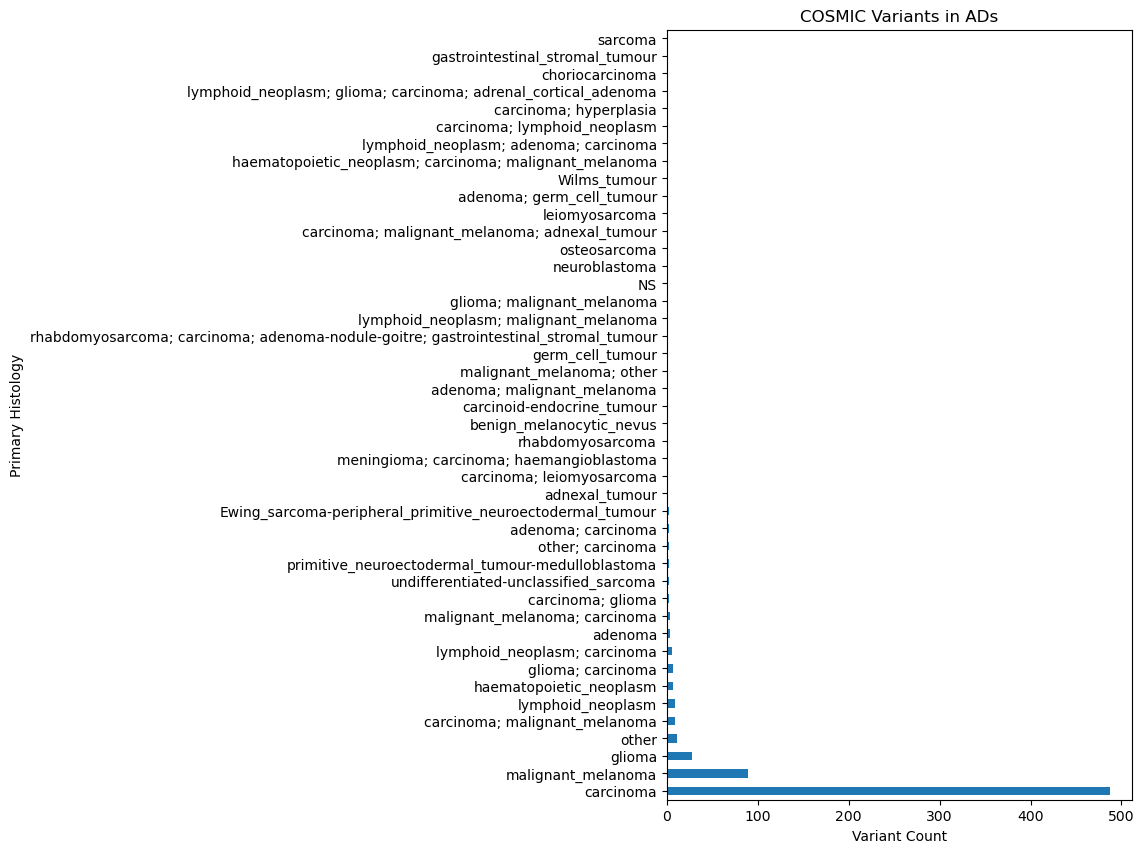

In [44]:
plt.figure(figsize=(6, 10))
cosmic_info[4].value_counts().plot(kind = "barh");

plt.ylabel("Primary Histology")
plt.xlabel("Variant Count")
plt.title("COSMIC Variants in ADs");

In [45]:
cosmic_info[5] = cosmic_info[5].str.split(";")
cosmic_info_exploded = cosmic_info.explode(5)
cosmic_info[5]

0                      [large_intestine]
0                               [breast]
0                              [stomach]
0                                [ovary]
0                               [cervix]
                    ...                 
0                      [large_intestine]
0                                [ovary]
0                               [cervix]
0    [large_intestine,  ovary,  stomach]
0                           [oesophagus]
Name: 5, Length: 698, dtype: object

In [46]:
cosmic_info_exploded[5] = cosmic_info_exploded[5].str.strip()
cosmic_info_exploded[5].value_counts()

5
skin                                  138
lung                                  137
large_intestine                       116
endometrium                            54
stomach                                52
central_nervous_system                 42
breast                                 31
urinary_tract                          29
haematopoietic_and_lymphoid_tissue     27
upper_aerodigestive_tract              24
liver                                  23
oesophagus                             18
kidney                                 15
NS                                     15
prostate                               13
thyroid                                 9
biliary_tract                           9
pancreas                                9
soft_tissue                             9
ovary                                   7
small_intestine                         6
cervix                                  4
bone                                    3
testis                          

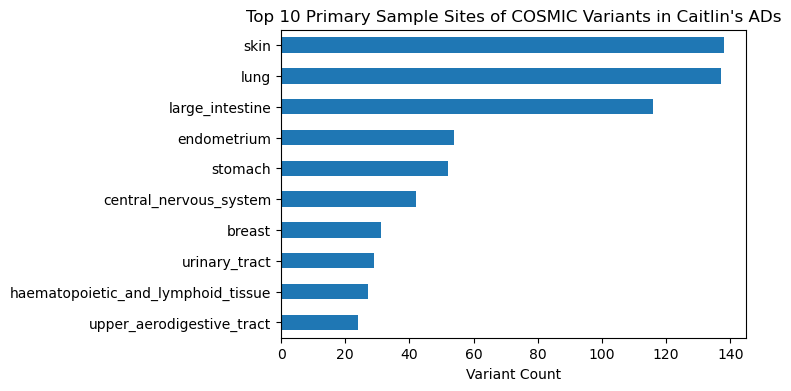

In [47]:
plt.figure(figsize=(6, 4))

cosmic_info_exploded[5].value_counts(ascending = False)[:10].sort_values(ascending = True).plot(kind = "barh")
plt.ylabel("")
plt.xlabel("Variant Count")
plt.title("Top 10 Primary Sample Sites of COSMIC Variants in Caitlin's ADs");

In [48]:
cosmic_info_exploded[5].value_counts(ascending = True)

5
meninges                                1
autonomic_ganglia                       1
adrenal_gland                           1
placenta                                1
penis                                   1
salivary_gland                          2
testis                                  2
bone                                    3
cervix                                  4
small_intestine                         6
ovary                                   7
thyroid                                 9
biliary_tract                           9
pancreas                                9
soft_tissue                             9
prostate                               13
kidney                                 15
NS                                     15
oesophagus                             18
liver                                  23
upper_aerodigestive_tract              24
haematopoietic_and_lymphoid_tissue     27
urinary_tract                          29
breast                          

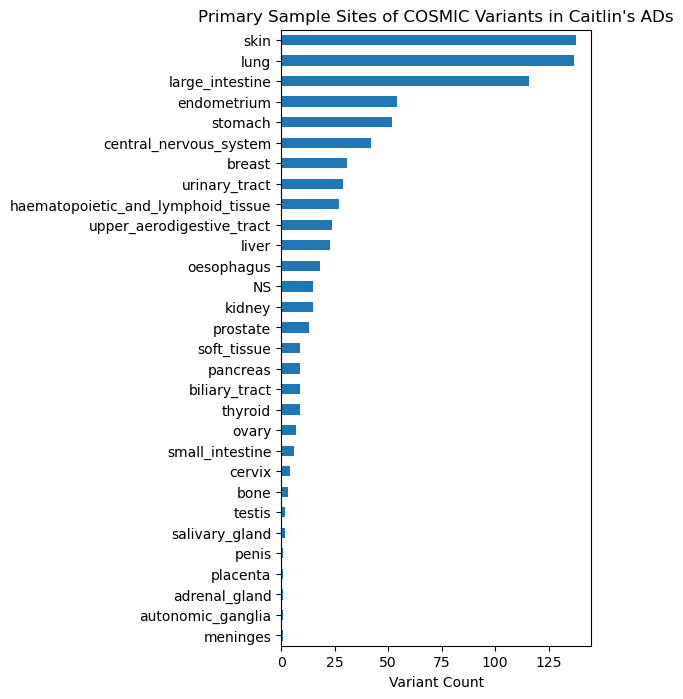

In [49]:
plt.figure(figsize=(4, 8))

cosmic_info_exploded[5].value_counts(ascending = True).plot(kind = "barh")
plt.ylabel("")
plt.xlabel("Variant Count")
plt.title("Primary Sample Sites of COSMIC Variants in Caitlin's ADs");

In [50]:
AD_vars_share_format_cc_names["Gene"] = AD_vars_share_format_cc_names["Gene Name"].str.split("_").str[0]
AD_vars_share_format_cc_names["pos"] = AD_vars_share_format_cc_names["Protein Change"].str.extract(r"(\d+)")
AD_vars_share_format_cc_names

,Gene Name,Mutant Sequence,Protein Change,Mutation,Gene,pos
0,CAMTA2_AD1,KVHTSPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ala286Val,cosmic,CAMTA2,286
1,CAMTA2_AD1,KAHTFPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser289Phe,cosmic,CAMTA2,289
2,CAMTA2_AD1,KAHTSPSSFSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser293Phe,cosmic,CAMTA2,293
3,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAETLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Pro304Thr,cosmic,CAMTA2,304
4,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAEPLEMRPSPPTSRGGSSRGGTAILLLTG...,p.Ile307Met,cosmic,CAMTA2,307
...,...,...,...,...,...,...
647,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACLYGTPASPYSVYRDTCN...,p.Pro263Leu,cosmic,PITX1,263
648,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYSTPASPYSVYRDTCN...,p.Gly265Ser,cosmic,PITX1,265
649,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPAWPYSVYRDTCN...,p.Ser269Trp,cosmic,PITX1,269
650,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPASPYSIYRDTCN...,p.Val273Ile,cosmic,PITX1,273


In [51]:
import re

# Dictionary mapping three-letter amino acid codes to one-letter codes
aa_dict = {
    'Ala': 'A', 'Cys': 'C', 'Asp': 'D', 'Glu': 'E', 'Phe': 'F', 'Gly': 'G', 'His': 'H', 
    'Ile': 'I', 'Lys': 'K', 'Leu': 'L', 'Met': 'M', 'Asn': 'N', 'Pro': 'P', 'Gln': 'Q', 
    'Arg': 'R', 'Ser': 'S', 'Thr': 'T', 'Val': 'V', 'Trp': 'W', 'Tyr': 'Y'
}

# Function to convert mutations
def convert_mutation(mutation):
    # Extract the three-letter amino acid names and the number
    match = re.match(r'p\.([A-Za-z]{3})(\d+)([A-Za-z]{3})', mutation)
    if match:
        aa1 = match.group(1)  # First amino acid (3-letter)
        position = match.group(2)  # Position
        aa2 = match.group(3)  # Second amino acid (3-letter)
        # Convert to one-letter codes using the dictionary
        return f"p.{aa_dict[aa1]}{position}{aa_dict[aa2]}"
    return mutation

# Apply the function to the DataFrame column
AD_vars_share_format_cc_names['mutation'] = AD_vars_share_format_cc_names['Protein Change'].apply(convert_mutation)

AD_vars_share_format_cc_names

,Gene Name,Mutant Sequence,Protein Change,Mutation,Gene,pos,mutation
0,CAMTA2_AD1,KVHTSPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ala286Val,cosmic,CAMTA2,286,p.A286V
1,CAMTA2_AD1,KAHTFPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser289Phe,cosmic,CAMTA2,289,p.S289F
2,CAMTA2_AD1,KAHTSPSSFSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser293Phe,cosmic,CAMTA2,293,p.S293F
3,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAETLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Pro304Thr,cosmic,CAMTA2,304,p.P304T
4,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAEPLEMRPSPPTSRGGSSRGGTAILLLTG...,p.Ile307Met,cosmic,CAMTA2,307,p.I307M
...,...,...,...,...,...,...,...
647,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACLYGTPASPYSVYRDTCN...,p.Pro263Leu,cosmic,PITX1,263,p.P263L
648,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYSTPASPYSVYRDTCN...,p.Gly265Ser,cosmic,PITX1,265,p.G265S
649,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPAWPYSVYRDTCN...,p.Ser269Trp,cosmic,PITX1,269,p.S269W
650,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPASPYSIYRDTCN...,p.Val273Ile,cosmic,PITX1,273,p.V273I


In [52]:
AD_vars_share_format_cc_names[AD_vars_share_format_cc_names["Gene Name"].str.contains("ERG")]

,Gene Name,Mutant Sequence,Protein Change,Mutation,Gene,pos,mutation
74,ERG_AD1,PYPPALPVTSSSFFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.His434Tyr,cosmic,ERG,434,p.H434Y
75,ERG_AD1,PHTPALPVTSSSFFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.Pro435Thr,cosmic,ERG,435,p.P435T
76,ERG_AD1,PHPAALPVTSSSFFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.Pro436Ala,cosmic,ERG,436,p.P436A
77,ERG_AD1,PHPSALPVTSSSFFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.Pro436Ser,cosmic,ERG,436,p.P436S
78,ERG_AD1,PHPPVLPVTSSSFFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.Ala437Val,cosmic,ERG,437,p.A437V
...,...,...,...,...,...,...,...
166,ERG_AD2,MTTNERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,p.Pro255Leu,cosmic,ERG,255,p.P255L
167,ERG_AD2,MTTNERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,p.Arg257Lys,cosmic,ERG,257,p.R257K
168,ERG_AD2,MTTNERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,p.Ser258Leu,cosmic,ERG,258,p.S258L
169,ERG_AD2,MTTNERRVIVPADPTLWSTDHVRQWLEWAVKEYGLPDVNILLFQNI...,p.Ala259Ser,cosmic,ERG,259,p.A259S


In [53]:
cosmic_info_exploded_merged = pd.merge(cosmic_info_exploded, AD_vars_share_format_cc_names, 
         right_on = ["Gene", "mutation"],
        left_on = [1, 3])
cosmic_info_exploded_merged       

,0,1,2,3,4,5,Gene Name,Mutant Sequence,Protein Change,Mutation,Gene,pos,mutation
0,112303462,CAMTA2,c.857C>T,p.A286V,carcinoma,large_intestine,CAMTA2_AD1,KVHTSPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ala286Val,cosmic,CAMTA2,286,p.A286V
1,112299293,CAMTA2,c.866C>T,p.S289F,carcinoma,breast,CAMTA2_AD1,KAHTFPSSSSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser289Phe,cosmic,CAMTA2,289,p.S289F
2,112298347,CAMTA2,c.878C>T,p.S293F,carcinoma,stomach,CAMTA2_AD1,KAHTSPSSFSSSSSSGFAEPLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Ser293Phe,cosmic,CAMTA2,293,p.S293F
3,112306887,CAMTA2,c.910C>A,p.P304T,carcinoma,ovary,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAETLEIRPSPPTSRGGSSRGGTAILLLTG...,p.Pro304Thr,cosmic,CAMTA2,304,p.P304T
4,112300741,CAMTA2,c.921C>G,p.I307M,carcinoma,cervix,CAMTA2_AD1,KAHTSPSSSSSSSSSGFAEPLEMRPSPPTSRGGSSRGGTAILLLTG...,p.Ile307Met,cosmic,CAMTA2,307,p.I307M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,105663124,PITX1,c.806C>G,p.S269W,carcinoma,cervix,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPAWPYSVYRDTCN...,p.Ser269Trp,cosmic,PITX1,269,p.S269W
752,105662713,PITX1,c.817G>A,p.V273I,carcinoma,large_intestine,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPASPYSIYRDTCN...,p.Val273Ile,cosmic,PITX1,273,p.V273I
753,105662713,PITX1,c.817G>A,p.V273I,carcinoma,ovary,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPASPYSIYRDTCN...,p.Val273Ile,cosmic,PITX1,273,p.V273I
754,105662713,PITX1,c.817G>A,p.V273I,carcinoma,stomach,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYGTPASPYSIYRDTCN...,p.Val273Ile,cosmic,PITX1,273,p.V273I


In [54]:
cosmic_info_exploded

,0,1,2,3,4,5
0,112303462,CAMTA2,c.857C>T,p.A286V,carcinoma,large_intestine
0,112299293,CAMTA2,c.866C>T,p.S289F,carcinoma,breast
0,112298347,CAMTA2,c.878C>T,p.S293F,carcinoma,stomach
0,112306887,CAMTA2,c.910C>A,p.P304T,carcinoma,ovary
0,112300741,CAMTA2,c.921C>G,p.I307M,carcinoma,cervix
...,...,...,...,...,...,...
0,105663124,PITX1,c.806C>G,p.S269W,carcinoma,cervix
0,105662713,PITX1,c.817G>A,p.V273I,carcinoma,large_intestine
0,105662713,PITX1,c.817G>A,p.V273I,carcinoma,ovary
0,105662713,PITX1,c.817G>A,p.V273I,carcinoma,stomach


In [55]:
cosmic_info_exploded_grouped = pd.DataFrame(cosmic_info_exploded_merged.groupby(["Gene Name", 5]).size()).reset_index()
cosmic_info_exploded_grouped

,Gene Name,5,0
0,CAMTA2_AD1,bone,2
1,CAMTA2_AD1,breast,2
2,CAMTA2_AD1,central_nervous_system,2
3,CAMTA2_AD1,cervix,1
4,CAMTA2_AD1,endometrium,4
...,...,...,...
201,PITX1_AD,lung,3
202,PITX1_AD,oesophagus,2
203,PITX1_AD,ovary,2
204,PITX1_AD,skin,4


In [56]:
cosmic_info_pivot = pd.pivot_table(cosmic_info_exploded_grouped, values=0, index=5,
                       columns="Gene Name", aggfunc="sum").fillna(0).rename_axis(None, axis=1)
cosmic_info_pivot["sum"] = cosmic_info_pivot.loc[:,:].sum(axis=1)
cosmic_info_pivot = cosmic_info_pivot.sort_values(by = "sum", ascending = False)
cosmic_info_pivot = cosmic_info_pivot.drop(columns = "sum")
cosmic_info_pivot

,CAMTA2_AD1,CAMTA2_AD2,ERG_AD1,ERG_AD2,IKZF1_AD,MEIS2_AD,NCOA1_AD2,NCOA1_AD3,NKX2-2_AD,NR4A2_AD1,NR4A2_AD2,OTX1_AD,PAX5_AD,PAX6_AD,PITX1_AD
5,,,,,,,,,,,,,,,
skin,7.0,9.0,7.0,14.0,17.0,13.0,7.0,11.0,2.0,4.0,0.0,16.0,15.0,8.0,4.0
lung,2.0,4.0,4.0,9.0,16.0,11.0,9.0,11.0,9.0,9.0,3.0,10.0,17.0,13.0,3.0
large_intestine,11.0,1.0,3.0,17.0,10.0,10.0,7.0,6.0,3.0,8.0,0.0,13.0,7.0,11.0,2.0
endometrium,4.0,2.0,0.0,6.0,6.0,2.0,4.0,5.0,1.0,3.0,0.0,9.0,5.0,2.0,1.0
stomach,3.0,0.0,4.0,6.0,7.0,5.0,4.0,1.0,1.0,1.0,0.0,6.0,1.0,5.0,3.0
central_nervous_system,2.0,1.0,3.0,6.0,4.0,1.0,4.0,3.0,1.0,1.0,0.0,13.0,3.0,0.0,0.0
breast,2.0,2.0,1.0,7.0,4.0,2.0,4.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
urinary_tract,1.0,2.0,0.0,4.0,3.0,1.0,2.0,3.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0
upper_aerodigestive_tract,4.0,2.0,0.0,4.0,3.0,4.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0


In [57]:
for col in cosmic_info_pivot.columns:
    cosmic_info_pivot[col] = cosmic_info_pivot[col] / sum(cosmic_info_pivot[col])

cosmic_info_pivot

,CAMTA2_AD1,CAMTA2_AD2,ERG_AD1,ERG_AD2,IKZF1_AD,MEIS2_AD,NCOA1_AD2,NCOA1_AD3,NKX2-2_AD,NR4A2_AD1,NR4A2_AD2,OTX1_AD,PAX5_AD,PAX6_AD,PITX1_AD
5,,,,,,,,,,,,,,,
skin,0.155556,0.28125,0.28,0.138614,0.177083,0.216667,0.129630,0.189655,0.076923,0.129032,0.00,0.170213,0.241935,0.166667,0.20
lung,0.044444,0.12500,0.16,0.089109,0.166667,0.183333,0.166667,0.189655,0.346154,0.290323,0.75,0.106383,0.274194,0.270833,0.15
large_intestine,0.244444,0.03125,0.12,0.168317,0.104167,0.166667,0.129630,0.103448,0.115385,0.258065,0.00,0.138298,0.112903,0.229167,0.10
endometrium,0.088889,0.06250,0.00,0.059406,0.062500,0.033333,0.074074,0.086207,0.038462,0.096774,0.00,0.095745,0.080645,0.041667,0.05
stomach,0.066667,0.00000,0.16,0.059406,0.072917,0.083333,0.074074,0.017241,0.038462,0.032258,0.00,0.063830,0.016129,0.104167,0.15
central_nervous_system,0.044444,0.03125,0.12,0.059406,0.041667,0.016667,0.074074,0.051724,0.038462,0.032258,0.00,0.138298,0.048387,0.000000,0.00
breast,0.044444,0.06250,0.04,0.069307,0.041667,0.033333,0.074074,0.068966,0.000000,0.000000,0.00,0.000000,0.032258,0.000000,0.10
urinary_tract,0.022222,0.06250,0.00,0.039604,0.031250,0.016667,0.037037,0.051724,0.115385,0.064516,0.00,0.063830,0.000000,0.000000,0.00
upper_aerodigestive_tract,0.088889,0.06250,0.00,0.039604,0.031250,0.066667,0.018519,0.017241,0.038462,0.032258,0.00,0.021277,0.016129,0.000000,0.00


In [58]:
cosmic_info_pivot = cosmic_info_pivot.reset_index().rename(columns = {5 : "Primary Sample Site", 1: "Gene"}).set_index("Primary Sample Site", drop = True)
cosmic_info_pivot.columns = cosmic_info_pivot.columns.get_level_values(0)
cosmic_info_pivot

,CAMTA2_AD1,CAMTA2_AD2,ERG_AD1,ERG_AD2,IKZF1_AD,MEIS2_AD,NCOA1_AD2,NCOA1_AD3,NKX2-2_AD,NR4A2_AD1,NR4A2_AD2,OTX1_AD,PAX5_AD,PAX6_AD,PITX1_AD
Primary Sample Site,,,,,,,,,,,,,,,
skin,0.155556,0.28125,0.28,0.138614,0.177083,0.216667,0.129630,0.189655,0.076923,0.129032,0.00,0.170213,0.241935,0.166667,0.20
lung,0.044444,0.12500,0.16,0.089109,0.166667,0.183333,0.166667,0.189655,0.346154,0.290323,0.75,0.106383,0.274194,0.270833,0.15
large_intestine,0.244444,0.03125,0.12,0.168317,0.104167,0.166667,0.129630,0.103448,0.115385,0.258065,0.00,0.138298,0.112903,0.229167,0.10
endometrium,0.088889,0.06250,0.00,0.059406,0.062500,0.033333,0.074074,0.086207,0.038462,0.096774,0.00,0.095745,0.080645,0.041667,0.05
stomach,0.066667,0.00000,0.16,0.059406,0.072917,0.083333,0.074074,0.017241,0.038462,0.032258,0.00,0.063830,0.016129,0.104167,0.15
central_nervous_system,0.044444,0.03125,0.12,0.059406,0.041667,0.016667,0.074074,0.051724,0.038462,0.032258,0.00,0.138298,0.048387,0.000000,0.00
breast,0.044444,0.06250,0.04,0.069307,0.041667,0.033333,0.074074,0.068966,0.000000,0.000000,0.00,0.000000,0.032258,0.000000,0.10
urinary_tract,0.022222,0.06250,0.00,0.039604,0.031250,0.016667,0.037037,0.051724,0.115385,0.064516,0.00,0.063830,0.000000,0.000000,0.00
upper_aerodigestive_tract,0.088889,0.06250,0.00,0.039604,0.031250,0.066667,0.018519,0.017241,0.038462,0.032258,0.00,0.021277,0.016129,0.000000,0.00


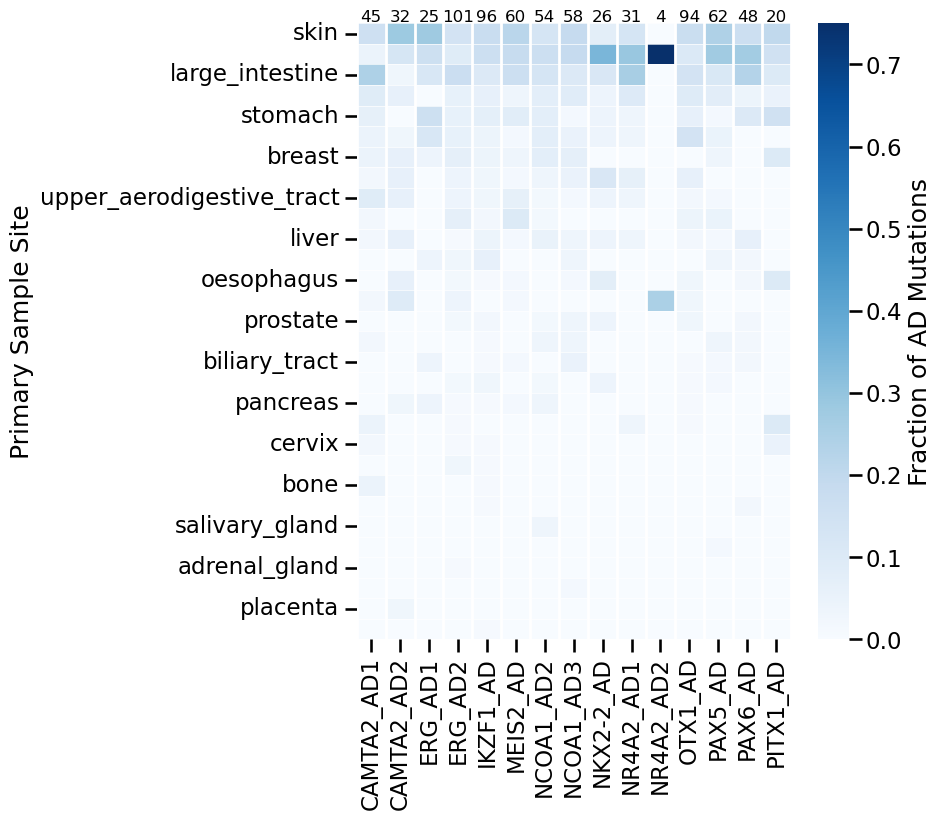

In [70]:
import seaborn as sns

sns.set_context('talk')
plt.figure(figsize=(7, 8))
ax = sns.heatmap(cosmic_info_pivot, fmt="g", cmap = sns.color_palette("Blues", as_cmap=True), cbar_kws={'label': 'Fraction of AD Mutations'})

for i in range(cosmic_info_pivot.shape[0] + 1):
    ax.axhline(i, color='white', lw=0.5)
for i in range(cosmic_info_pivot.shape[1] + 1):
    ax.axvline(i, color='white', lw=2)

counts = list(pd.DataFrame(cosmic_info_exploded_merged["Gene Name"].value_counts()).reset_index().sort_values(by = "Gene Name")["count"])


idx = 0
for count in counts:
    ax.text(idx + 0.5, -0.3, str(count), ha='center', va='center', fontsize=12, color='black')
    idx += 1

plt.show()

In [71]:
comic_vars_num_sort = pd.DataFrame(cosmic_info_exploded_merged["Gene Name"].value_counts()).reset_index().sort_values(by = "count", ascending = False)
comic_vars_num_sort

,Gene Name,count
0,ERG_AD2,101
1,IKZF1_AD,96
2,OTX1_AD,94
3,PAX5_AD,62
4,MEIS2_AD,60
5,NCOA1_AD3,58
6,NCOA1_AD2,54
7,PAX6_AD,48
8,CAMTA2_AD1,45
9,CAMTA2_AD2,32


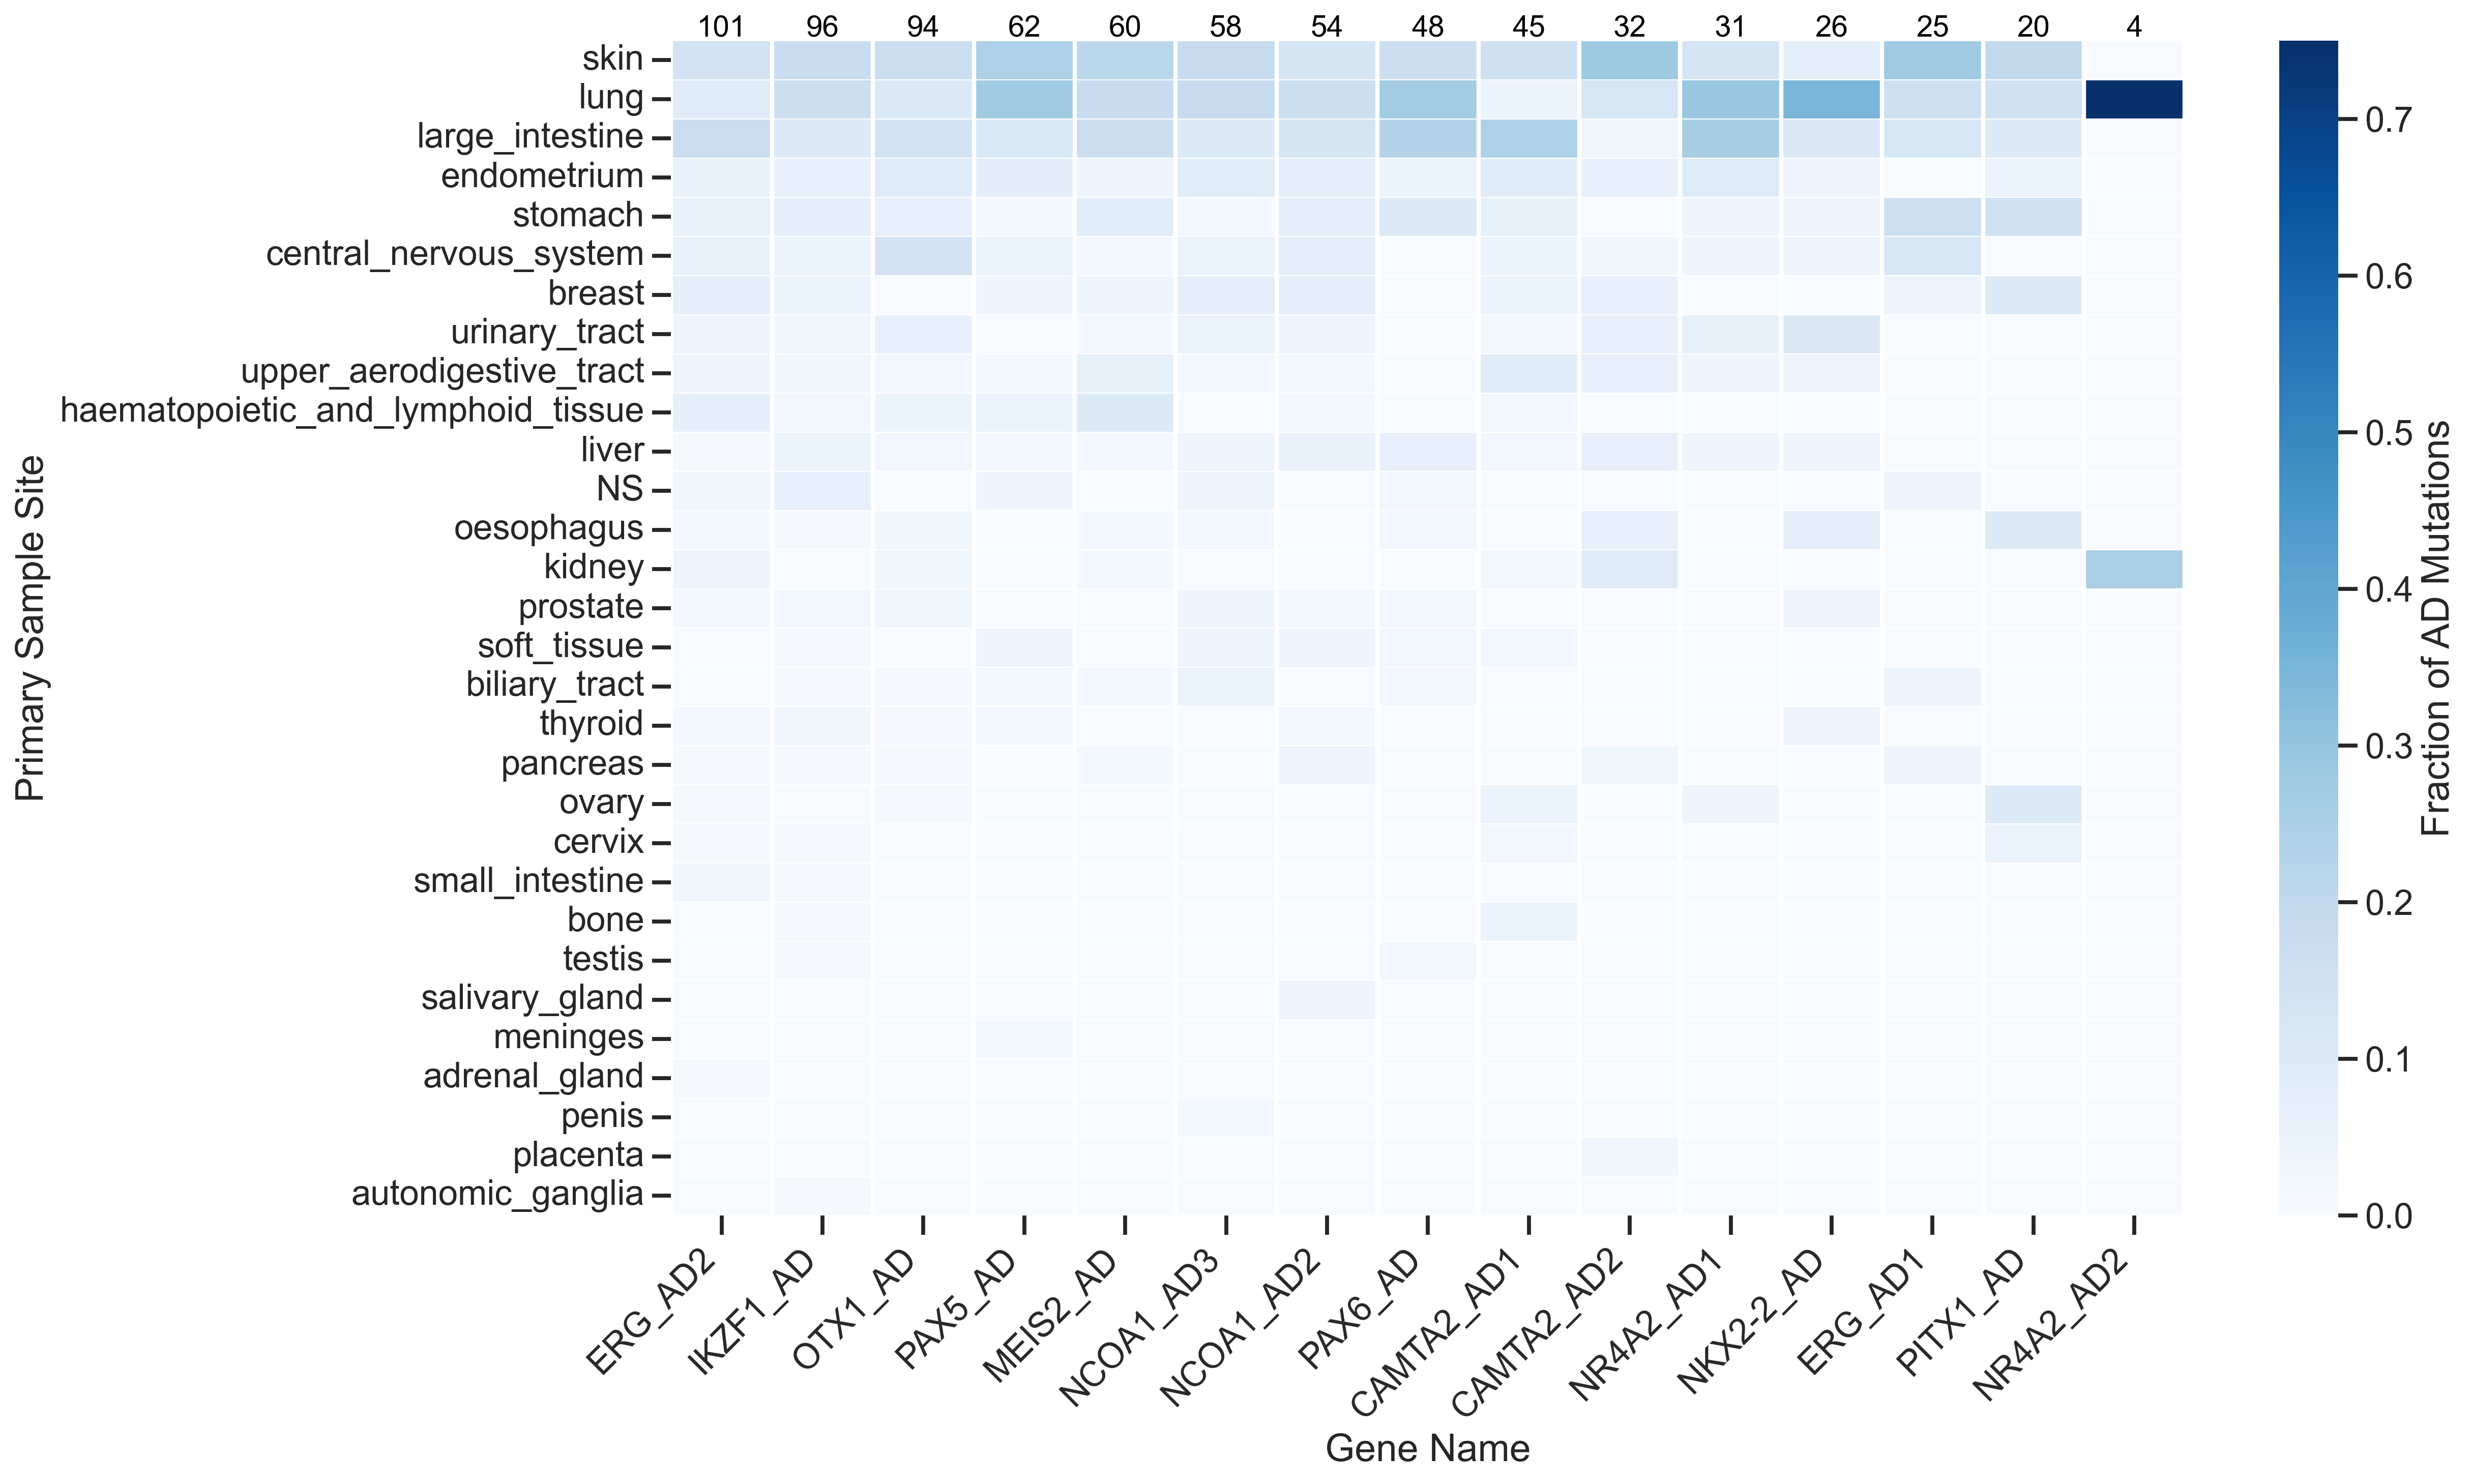

In [99]:
#import seaborn as sns

#plt.figure(figsize=(16, 10), dpi = 1000)
sns.set_theme(rc={'figure.dpi': 300, 'figure.figsize': (16, 10)})
sns.set_context('talk')
sns.set_style('ticks')
ax = sns.heatmap(cosmic_info_pivot.reindex(comic_vars_num_sort["Gene Name"], axis = 1), fmt="g", cmap = sns.color_palette("Blues", as_cmap=True), cbar_kws={'label': 'Fraction of AD Mutations'})
ax.set_xticklabels(comic_vars_num_sort["Gene Name"], rotation=45, ha = 'right')


for i in range(cosmic_info_pivot.shape[0] + 1):
    ax.axhline(i, color='white', lw=0.5)
for i in range(cosmic_info_pivot.shape[1] + 1):
    ax.axvline(i, color='white', lw=2)


idx = 0
for count in comic_vars_num_sort["count"]:
    ax.text(idx + 0.5, -0.3, str(count), ha='center', va='center', fontsize=14, color='black')
    idx += 1

plt.show()
